In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import IPython.display as ipd

В нас є якісь мікрофони, і джерело звуку. Хай перший мікрофон завжди в початку координат.

In [2]:
# (x, y) m
MIC_POSITIONS = [
    (0, 0),
    (100, 0),
    (0, 100),
    (100, 100),
    (100, 500)
]
SOUND_POSITION = (2000, 1000)

Розраховуємо відстань від джерела звуку до мікрофонів (м)

In [3]:
from scipy.spatial import distance

distances = [distance.euclidean(mic, SOUND_POSITION) for mic in MIC_POSITIONS]
print(distances)

[2236.06797749979, 2147.091055358389, 2193.171219946131, 2102.379604162864, 1964.68827043885]


Та час прильоту звуку (Time of Arrival, c)

In [4]:
SPEED_OF_SOUND = 343  # m/s
time_of_arrival = np.array([distance / SPEED_OF_SOUND for distance in distances])
print(time_of_arrival)

[6.51914862 6.25974069 6.39408519 6.1293866  5.72795414]


Але в нас не буде абсолютного часу, а буде тільки різниця. Тому навмання беремо 0 мікрофон — як базовий. І розраховуємо різницю часу прильоту (time difference of arrival, tdoa, c). Додаємо випадковий шум.

In [12]:
NOISE = np.random.normal(0, 0.001, len(MIC_POSITIONS))

tdoa = np.array([time - time_of_arrival[0] for time in time_of_arrival])
print('clean', tdoa)

toa_noisy = time_of_arrival + NOISE
tdoa_noisy = np.array([time - toa_noisy[0] for time in toa_noisy])
print('noisy', tdoa_noisy)

clean [ 0.         -0.25940794 -0.12506343 -0.38976202 -0.79119448]
noisy [ 0.         -0.25936759 -0.12882544 -0.39356018 -0.79334563]


# Пішли матриці

Цю формулу я зкопіював, вона пов'язує координати 2 мікрофонів, з джерелом звуку (лінійно)

$$ (\frac{2 x_m}{v_s\tau_m}-\frac{2 x_1}{v_s\tau_1})x + (\frac{2 y_m}{v_s\tau_m}-\frac{2 y_1}{v_s\tau_1})y = (\frac{{x_m}^2 + {y_m}^2}{v_s\tau_m} - \frac{{x_1}^2 + {y_1}^2}{v_s\tau_1}) - (v_s\tau_m - v_s\tau_1)$$


In [13]:
def coefs(pos_m, t_m, pos_1, t_1):
    (x_m, y_m) = pos_m
    (x_1, y_1) = pos_1
    v = SPEED_OF_SOUND
    a = (2 * x_m) / (v * t_m) - (2 * x_1) / (v * t_1)
    b = (2 * y_m) / (v * t_m) - (2 * y_1) / (v * t_1)
    c = (x_m ** 2 + y_m ** 2) / (v * t_m) - (x_1 ** 2 + y_1 ** 2) / (v * t_1) - (v * t_m - v * t_1)

    return a, b, c

Будуємо систему рівнянь і вирішуємо її

In [14]:
def solve(tdoa):
    M = np.array([coefs(MIC_POSITIONS[m], tdoa[m], MIC_POSITIONS[1], tdoa[1]) for m in range(2, len(MIC_POSITIONS))])
    
    a = M[: , [0,1]]  # first two columns
    b = M[: , [2]]    # last column
    return list(np.linalg.lstsq(a, b, rcond=None)[0].flat)

clean_xy = solve(tdoa)
print(clean_xy)

noisy_xy = solve(tdoa_noisy)
print(noisy_xy)

[1999.9999999999789, 999.999999999994]
[1713.1888763489703, 885.2135198266685]


Малюємо
- мікрофони зелені
- джерело звуку зелений кружечок
- результат без шуму - синій хрестик
- результат з шумом - червоний хрестик

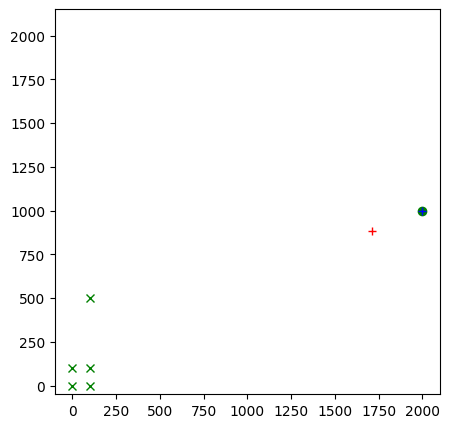

In [15]:
plt.figure(figsize=(10, 5))

# show mics
for x, y in MIC_POSITIONS:
    plt.plot(x, y, marker="x", color="green")

# show sound
plt.plot(SOUND_POSITION[0], SOUND_POSITION[1], marker="o", color="green")
plt.plot(clean_xy[0], clean_xy[1], marker="+", color="blue")
plt.plot(noisy_xy[0], noisy_xy[1], marker="+", color="red")

plt.axis('square')
plt.show()